In [1]:
import os
import sys
import random
import itertools
import inspect
import multiprocess
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import sqrt
from  warnings import simplefilter
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning

In [2]:
random.seed(0)
simplefilter('ignore', category = ConvergenceWarning)

In [3]:
df_training = pd.read_csv('../../datasets/titanic_training_processed.csv')
df_test = pd.read_csv('../../datasets/titanic_test_processed.csv')

In [4]:
df_training.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_3,Pclass_1,Sex_male,TicketPrefix_A/5,...,CabinClass_C,CabinClass_E,CabinClass_G,CabinClass_D,CabinClass_A,CabinClass_B,CabinClass_F,Embarked_S,Embarked_C,Embarked_Q
0,1,0,-0.565419,0.432550,-0.473408,-0.502163,0.902081,-0.565368,0.737281,9.380891,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739
1,2,1,0.663488,0.432550,-0.473408,0.786404,-1.107304,1.766775,-1.354813,-0.106480,...,3.753114,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,-1.613803,2.073341,-0.30739
2,3,1,-0.258192,-0.474279,-0.473408,-0.488580,0.902081,-0.565368,-1.354813,-0.106480,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739
3,4,1,0.433068,0.432550,-0.473408,0.420494,-1.107304,1.766775,-1.354813,-0.106480,...,3.753114,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739
4,5,0,0.433068,-0.474279,-0.473408,-0.486064,0.902081,-0.565368,0.737281,-0.106480,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739


In [5]:
df_test.head()

,PassengerId,Age,SibSp,Parch,Fare,Pclass_3,Pclass_1,Sex_male,TicketPrefix_A/5,TicketPrefix_PC,...,CabinClass_C,CabinClass_E,CabinClass_G,CabinClass_D,CabinClass_A,CabinClass_B,CabinClass_F,Embarked_S,Embarked_C,Embarked_Q
0,892,0.394665,-0.474279,-0.473408,-0.490508,0.902081,-0.565368,0.737281,-0.10648,-0.268554,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,-1.613803,-0.481772,3.249548
1,893,1.354749,0.432550,-0.473408,-0.507194,0.902081,-0.565368,-1.354813,-0.10648,-0.268554,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.307390
2,894,2.506849,-0.474279,-0.473408,-0.453112,-1.107304,-0.565368,0.737281,-0.10648,-0.268554,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,-1.613803,-0.481772,3.249548
3,895,-0.181385,-0.474279,-0.473408,-0.473739,0.902081,-0.565368,0.737281,-0.10648,-0.268554,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.307390
4,896,-0.565419,0.432550,0.767199,-0.400792,0.902081,-0.565368,-1.354813,-0.10648,-0.268554,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.307390


In [6]:
columns = df_training.columns[2:]
X_train = df_training[columns].values
X_test = df_test[columns].values
y_train = df_training['Survived'].values

In [7]:
X_train.shape

(891, 60)

In [8]:
X_test.shape

(418, 60)

In [9]:
y_train.shape

(891,)

## No feature selection

We have to still apply 10-fold cross validation to select the kernel and the value of C. For the polynomial and RBF kernels we also need to determine the value of their respective parameters  

In [10]:
# generating sets for 10-fold cross validation
indexes = list(range(len(df_training)))
random.shuffle(indexes)
folds = []
for i in range(10):
    folds.append([])
for i in range(len(indexes)):
    folds[i % 10].append(indexes[i])

In [11]:
def produce_training_test_set(df_training, train_indexes, test_indexes, column_indexes):
    columns = df_training.columns[column_indexes]
    datasets = {}
    datasets['X_train'] = df_training.iloc[train_indexes][columns].values
    datasets['X_test'] = df_training.iloc[test_indexes][columns].values
    datasets['y_train'] = df_training.iloc[train_indexes]['Survived'].values
    datasets['y_test'] = df_training.iloc[test_indexes]['Survived'].values
    
    return datasets

In [12]:
def evaluate(datasets, C, kernel, kernel_params):
    kwargs = {}
    if kernel == 'poly':
        kwargs['degree'] = kernel_params['degree']
        kwargs['coef0'] = kernel_params['coef0']
       
    clf = SVC(max_iter = 50000, C = C, gamma = 'auto', kernel = kernel, **kwargs)
    clf.fit(datasets['X_train'], datasets['y_train'])
    y_pred = clf.predict(datasets['X_test'])
    return sqrt(np.sum(np.power(np.array(y_pred) - np.array(datasets['y_test']), 2)))

In [13]:
def k_fold_cross_validation(df_training, folds, column_indexes, C, kernel, kernel_params):
    error = 0
    
    for k in range(10):
        train_indexes = []
        for j in range(10):
            if j == k:
                test_indexes = folds[j]
            else:
                train_indexes = train_indexes + folds[j]
                
        datasets = produce_training_test_set(df_training, train_indexes, test_indexes, column_indexes)
        
        error = error + evaluate(datasets, C, kernel, kernel_params)
        
    return error / 10.0

In [14]:
# Results were very similar for gamma = scale and gamma = auto
# No good results with degree = 1
# Manually setting the ranges and steps after testing multiple times so we do not get so many combinations
# for the feature selection case
C = np.arange(0.2, 5.2, 0.2).tolist()
kernel = ['linear', 'poly', 'rbf']
degree = [2, 3]
coef0 = np.arange(0, 3.2, 0.2).tolist()

poly_params = list(itertools.product(*[degree, coef0]))

comb = list(itertools.product(*[C, ['linear'], [None], [None]]))
comb.extend(list(itertools.product(*[C, ['rbf'], [None], [None]])))
comb.extend(list(itertools.product(*[C, ['poly'], degree, coef0])))

column_indexes = list(range(2, 62)) # All columns
minimum = sys.float_info.max

errors = pd.DataFrame(data = comb, columns = ['C', 'kernel', 'degree', 'coef0'])
errors['error'] = np.nan

for i in tqdm(range(len(errors))):
    errors.loc[i, 'error'] = k_fold_cross_validation(df_training,
                                                     folds,
                                                     column_indexes,
                                                     errors['C'].loc[i],
                                                     errors['kernel'].loc[i],
                                                     {'degree': errors['degree'].loc[i],
                                                      'coef0': errors['coef0'].loc[i]})

100%|██████████| 850/850 [04:18<00:00,  3.28it/s]


In [15]:
errors = errors.sort_values(by = 'error')
errors.head(5)

,C,kernel,degree,coef0,error
723,4.4,poly,2.0,0.2,3.904955
143,0.6,poly,3.0,2.6,3.913840
799,4.8,poly,2.0,2.6,3.915497
797,4.8,poly,2.0,2.2,3.915497
796,4.8,poly,2.0,2.0,3.915497


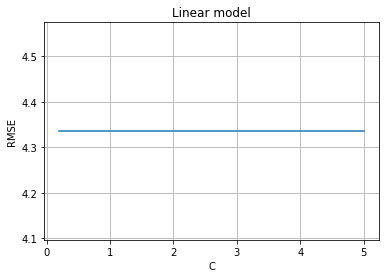

In [16]:
fig, ax = plt.subplots()
errors_linear = errors[errors.kernel == 'linear'].sort_values(by = 'C')
ax.plot(errors_linear.C, errors_linear.error)
ax.set_xlabel('C')
ax.set_ylabel('RMSE')
ax.set_title('Linear model')
ax.grid(True)

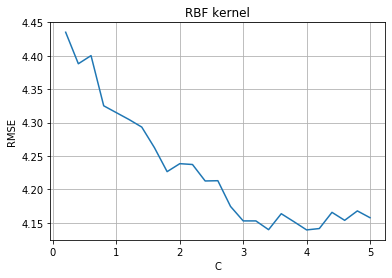

In [17]:
fig, ax = plt.subplots()
errors_rbf = errors[errors.kernel == 'rbf'].sort_values(by = 'C')
ax.plot(errors_rbf.C, errors_rbf.error)
ax.set_xlabel('C')
ax.set_ylabel('RMSE')
ax.set_title('RBF kernel')
ax.grid(True)

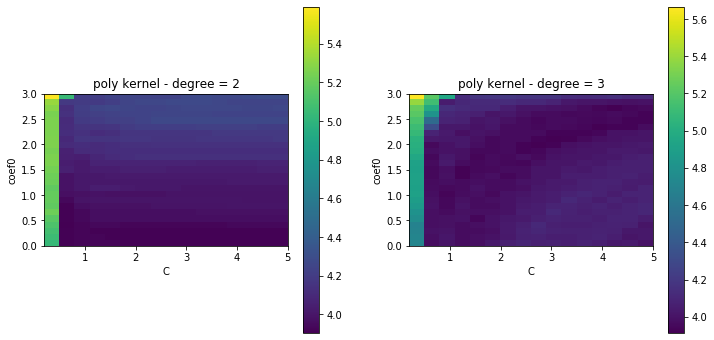

In [18]:
fig, ax = plt.subplots(1, len(degree))
errors_poly = errors[errors.kernel == 'poly']
for d in degree:
    i = degree.index(d)
    errors_d = errors_poly[errors_poly.degree == d].pivot(index='C', 
                                                          columns='coef0', 
                                                          values='error')
    im = ax[i].imshow(errors_d, cmap = 'viridis', extent=[errors.C.min(), 
                                                          errors.C.max(), 
                                                          errors.coef0.min(), 
                                                          errors.coef0.max()])
    fig.colorbar(im, ax = ax[i])
    ax[i].set_xlabel('C')
    ax[i].set_ylabel('coef0')
    ax[i].set_title('poly kernel - degree = ' + str(d))
fig.set_figwidth(12)
fig.set_figheight(6)

In [19]:
best_C = errors.C.values[0]
best_kernel = errors.kernel.values[0]
best_degree = errors.degree.values[0]
best_coef0 = errors.coef0.values[0]
clf = SVC(C = best_C, 
          gamma = 'auto', 
          kernel = best_kernel, 
          degree = best_degree,
          coef0 = best_coef0)

In [20]:
clf.fit(X_train, y_train)

SVC(C=4.4, break_ties=False, cache_size=200, class_weight=None, coef0=0.2,
    decision_function_shape='ovr', degree=2.0, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
y_test = clf.predict(X_test)

In [22]:
submission = df_test.copy()
submission['Survived'] = y_test
submission = submission[['PassengerId', 'Survived']]

In [23]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [24]:
if not os.path.exists('./submissions/'):
    os.makedirs('./submissions/')

In [25]:
submission.to_csv('./submissions/05_svm.csv', index = False)

My submission to Kaggle produced a 78.95% test prediction accuracy. This is almost as high as what I my best result *with feature selection* to this date.

## Feature selection - forward selection

In [26]:
def k_fold_cross_validation_unpack(args):
    from tmp_func import k_fold_cross_validation
    
    return k_fold_cross_validation(args[0],
                                   args[1],
                                   args[2],
                                   args[3][0],
                                   args[3][1],
                                   {'degree': args[3][2], 'coef0': args[3][3]})

In [27]:
with open('tmp_func.py', 'w') as f:
    f.write('from math import sqrt\n')
    f.write('from sklearn.svm import SVC\n')
    f.write('import numpy as np\n')
    f.write(inspect.getsource(evaluate))
    f.write(inspect.getsource(produce_training_test_set))
    f.write(inspect.getsource(k_fold_cross_validation))

In [28]:
# Forward selection
pending = list(range(2, 62))
model = []
min_error = sys.float_info.max
num_processes = multiprocess.cpu_count() - 1

while len(pending) > 0:
    prev_error = min_error
    
    for i in tqdm(pending):
        new_model = model + [i]
        parameters = itertools.product([df_training], [folds], [new_model], comb)
        with multiprocess.Pool(processes = num_processes) as pool:
            errors = pool.map(k_fold_cross_validation_unpack, parameters)
       
        minimum = min(errors) 
        if minimum < min_error:
            min_error = minimum
            best_model = new_model
            feature = i
            best_comb = comb[np.argmin(errors)]
        
    if min_error < prev_error:
        print('Selecting feature ' + 
              df_training.columns[feature] + 
              '(C = ' + 
              str(best_comb[0]) +
              ', kernel = ' +
              best_comb[1] +
              ', degree = ' + 
              str(best_comb[2]) +
              ', coef0 = ' +
              str(best_comb[3]) + 
              ') - error decreased to ' +
              str(min_error))
        model = model + [feature]
        pending.remove(feature)
    else:
        print('END')
        break

  0%|          | 0/59 [00:00<?, ?it/s]

Selecting feature Sex_male(C = 0.2, kernel = linear, degree = None, coef0 = None) - error decreased to 4.328105960328346


  0%|          | 0/58 [00:00<?, ?it/s]

Selecting feature SibSp(C = 3.4000000000000004, kernel = poly, degree = 2, coef0 = 1.8) - error decreased to 4.2284158796251905


  0%|          | 0/57 [00:00<?, ?it/s]

Selecting feature Age(C = 1.0, kernel = rbf, degree = None, coef0 = None) - error decreased to 4.008932923396004


  0%|          | 0/56 [00:00<?, ?it/s]

Selecting feature Pclass_3(C = 1.8, kernel = rbf, degree = None, coef0 = None) - error decreased to 3.853354211457616


  0%|          | 0/55 [00:00<?, ?it/s]

Selecting feature CabinClass_E(C = 4.2, kernel = rbf, degree = None, coef0 = None) - error decreased to 3.7818835038621055


  0%|          | 0/54 [00:00<?, ?it/s]

Selecting feature TicketPrefix_S.O./P.P.(C = 3.6000000000000005, kernel = rbf, degree = None, coef0 = None) - error decreased to 3.7743686900927775


100%|██████████| 54/54 [58:07<00:00, 64.58s/it]  

END


In [29]:
model_forward = model
columns = df_training.columns[model_forward]
X_train = df_training[columns].values
X_test = df_test[columns].values
y_train = df_training['Survived'].values

In [30]:
kwargs = dict()
if best_comb[1] == 'poly':
    kwargs['degree'] = best_comb[2]['degree']
    kwargs['coef0'] = best_comb[3]['coef0']
       
clf = SVC(C = best_comb[0], gamma = 'auto', kernel = best_comb[1], **kwargs)

In [31]:
clf.fit(X_train, y_train)

SVC(C=3.6000000000000005, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [32]:
y_test = clf.predict(X_test)

In [33]:
submission = df_test.copy()
submission['Survived'] = y_test
submission = submission[['PassengerId', 'Survived']]

In [34]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [35]:
submission.to_csv('./submissions/05_svm_forward_selection.csv', index = False)

Even though we got a lower error with this subset of features as compared as to the whole set (RMSE = 3.77 vs RMSE = 3.9), this submissions only got a 76.55% accuracy on Kaggle vs. the 78.95% I got with the complete set. 

## Feature selection - backward elimination

In [36]:
# backward elimination
model = list(range(2, 62))
# Using the results for the full model's best model
min_error = k_fold_cross_validation(df_training, 
                                    folds, 
                                    column_indexes, 
                                    best_C, 
                                    best_kernel, 
                                    {'degree': best_degree, 
                                     'coef0': best_coef0})
num_processes = multiprocess.cpu_count() - 1

while len(model) > 0:
    prev_error = min_error
    
    for i in tqdm(model):
        new_model = model[:]
        new_model.remove(i)
        parameters = itertools.product([df_training], [folds], [new_model], comb)
        
        with multiprocess.Pool(processes = num_processes) as pool:
            errors = pool.map(k_fold_cross_validation_unpack, parameters)
        
        minimum = min(errors)
        
        if minimum < min_error:
            min_error = minimum
            best_model = new_model
            feature = i
            best_comb = comb[np.argmin(errors)]
            
    if min_error < prev_error:
        print('Removing feature ' + 
              df_training.columns[feature] + 
              '(C = ' + 
              str(best_comb[0]) +
              ', kernel = ' +
              best_comb[1] +
              ', degree = ' + 
              str(best_comb[2]) +
              ', coef0 = ' +
              str(best_comb[3]) + 
              ') - error decreased to ' +
              str(min_error))
        model = best_model
    else:
        print('END')
        break

  0%|          | 0/59 [00:00<?, ?it/s]

Removing feature CabinClass_F(C = 4.4, kernel = poly, degree = 2, coef0 = 0.2) - error decreased to 3.85511758365195


  0%|          | 0/58 [00:00<?, ?it/s]

Removing feature CabinClass_A(C = 4.0, kernel = poly, degree = 2, coef0 = 0.2) - error decreased to 3.8177613331460707


  0%|          | 0/57 [00:00<?, ?it/s]

Removing feature Embarked_S(C = 1.4000000000000001, kernel = poly, degree = 3, coef0 = 2.6) - error decreased to 3.7771260833804425


  0%|          | 0/56 [00:00<?, ?it/s]

Removing feature TicketPrefix_SW/PP(C = 2.4000000000000004, kernel = poly, degree = 3, coef0 = 1.4000000000000001) - error decreased to 3.752039981286933


  0%|          | 0/55 [00:00<?, ?it/s]

Removing feature TicketPrefix_A/5(C = 1.4000000000000001, kernel = poly, degree = 3, coef0 = 2.4000000000000004) - error decreased to 3.7238387197659257


100%|██████████| 55/55 [1:01:21<00:00, 66.94s/it]

END


In [37]:
model_backward = model
columns = df_training.columns[model_backward]
X_train = df_training[columns].values
X_test = df_test[columns].values
y_train = df_training['Survived'].values

In [38]:
kwargs = dict()
if best_comb[1] == 'poly':
    kwargs['degree'] = best_comb[2]
    kwargs['coef0'] = best_comb[3]
       
clf = SVC(C = best_comb[0], gamma = 'auto', kernel = best_comb[1], **kwargs)

In [39]:
clf.fit(X_train, y_train)

SVC(C=1.4000000000000001, break_ties=False, cache_size=200, class_weight=None,
    coef0=2.4000000000000004, decision_function_shape='ovr', degree=3,
    gamma='auto', kernel='poly', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [40]:
y_test = clf.predict(X_test)

In [41]:
submission = df_test.copy()
submission['Survived'] = y_test
submission = submission[['PassengerId', 'Survived']]

In [42]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [43]:
submission.to_csv('./submissions/05_svm_backward_elimination.csv', index = False)

This submission produced the same accuracy as the complete model in spite of having a lower RMSE. 

In [44]:
os.remove('./tmp_func.py')